#Importy oraz funckje

In [1]:
!pip install -q obci_readmanager

     |████████████████████████████████| 58 kB 1.9 MB/s 
     |████████████████████████████████| 6.2 MB 11.5 MB/s 


In [2]:
from obci_readmanager.signal_processing.read_manager import ReadManager #nasza biblioteka od braintecha
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit
import os
import math
print(os.getcwd())


%matplotlib inline
#py.rcParams['figure.figsize'] = [4, 3]


/content


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file1 = ReadManager('/content/drive/My Drive/Colab Notebooks/Pracownia_EEG/SSVEP/SSVEP_01.xml','/content/drive/My Drive/Colab Notebooks/Pracownia_EEG/SSVEP/SSVEP_01.raw','/content/drive/My Drive/Colab Notebooks/Pracownia_EEG/SSVEP/SSVEP_01.tag')
syg1 = file1.get_microvolt_samples()
Fs1 =float(file1.get_param('sampling_frequency'))#ustalamy jak probkowany byl nasz sygnal

file2 = ReadManager('/content/drive/My Drive/Colab Notebooks/Pracownia_EEG/SSVEP/SSVEP_02.xml','/content/drive/My Drive/Colab Notebooks/Pracownia_EEG/SSVEP/SSVEP_02.raw','/content/drive/My Drive/Colab Notebooks/Pracownia_EEG/SSVEP/SSVEP_02.tag')
syg2 = file2.get_microvolt_samples()
Fs2 =float(file2.get_param('sampling_frequency'))

2022-05-12 17:22:44,618 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...
2022-05-12 17:23:50,184 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [20]:
print(Fs2)
print(syg1.shape)# sprawdzamy jak pod względem wymiarów wygląda nasz sygnał
print(syg2.shape)

  
Nazwy =['O1','O2','P7','P3','Pz','P4','P8','Cz','Fp1','Fpz','Fp2','A1','A2','Trig1']


fstimuli1 = np.load('/content/drive/My Drive/Colab Notebooks/Pracownia_EEG/SSVEP/Seria1.npy') # pierwszej kolumnie f stimuli, w drugiej czas wystąpienia
fstimuli2 = np.load('/content/drive/My Drive/Colab Notebooks/Pracownia_EEG/SSVEP/Seria2.npy')

print(syg1[13].shape)

1024.0
(14, 1524704)
(14, 1541856)
(1524704,)


In [6]:
#filtrowanie
from  scipy.signal import freqz, group_delay #funkcja obliczająca funkcję systemu
from  scipy.signal import firwin, firwin2     # funkcje do projektowania filtrów FIR
from  scipy.signal import butter, buttord     # funkcje do projektowania filtrów  
from  scipy.signal import cheby1, cheb1ord    # funkcje do projektowania filtrów 
from  scipy.signal import cheby2, cheb2ord    # funkcje do projektowania filtrów 
from  scipy.signal import ellip, ellipord     # funkcje do projektowania filtrów eliptycznych
from  scipy.signal import lfilter, filtfilt # funkcje do aplikowania filtrów

fs = Fs1
[b,a]=butter(4,45/(fs/2),btype='low')
[b1,a1]=butter(4,1/(fs/2),btype='high')
#[b2,a2]=butter(4,(9/(fs/2),11/(fs/2)),btype='bandstop')


Fdane1=np.arange(14*len(syg1[0]),dtype='float').reshape(14, len(syg1[0]))
Fdane2=np.arange(14*len(syg2[0]),dtype='float').reshape(14, len(syg2[0]))
for i in range(len(Nazwy)-1):
  Fdane1[i]=(filtfilt(b,a,syg1[i]))
  Fdane1[i]=(filtfilt(b1,a1,Fdane1[i]))
  
  Fdane2[i]=(filtfilt(b,a,syg2[i]))
  Fdane2[i]=(filtfilt(b1,a1,Fdane2[i]))

for i in range(len(Nazwy)):
  Fdane1[i]=Fdane1[i]-(1/2)*(Fdane1[11]+Fdane1[12])
  Fdane2[i]=Fdane2[i]-(1/2)*(Fdane2[11]+Fdane2[12])

Fdane1[13],Fdane2[13]=syg1[13],syg2[13]

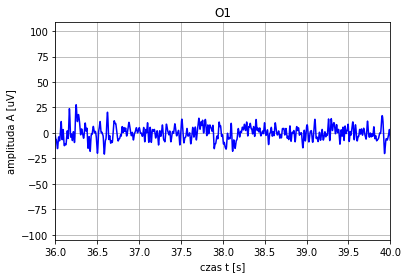

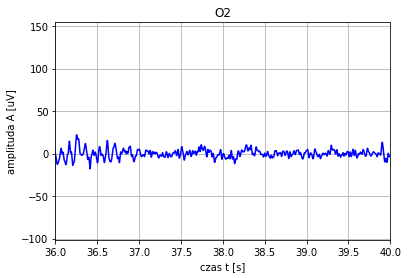

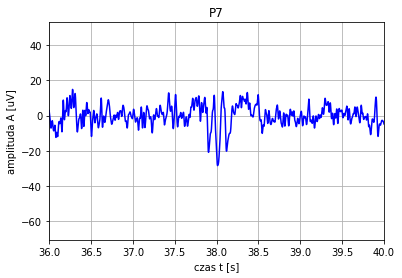

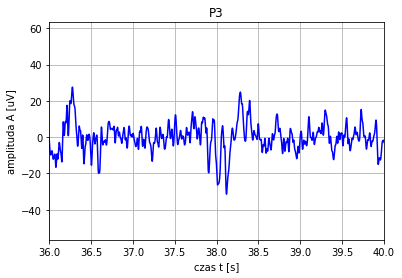

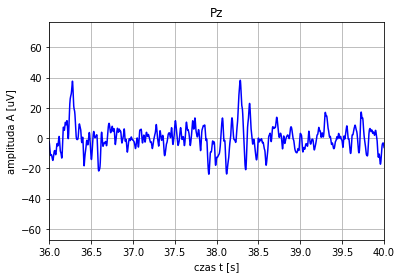

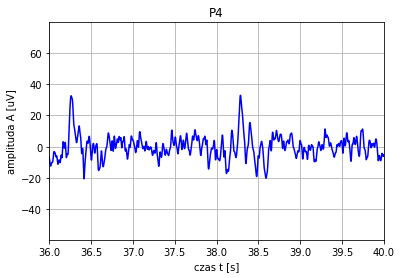

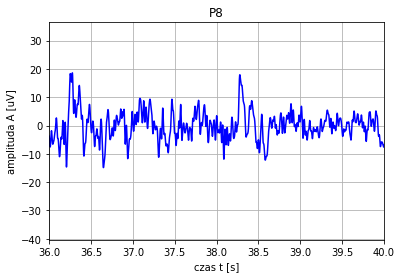

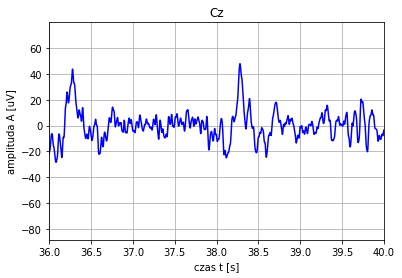

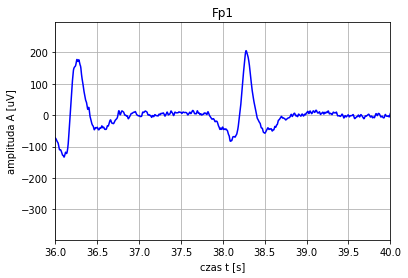

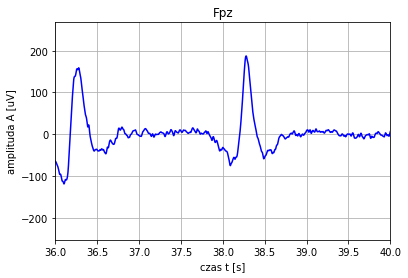

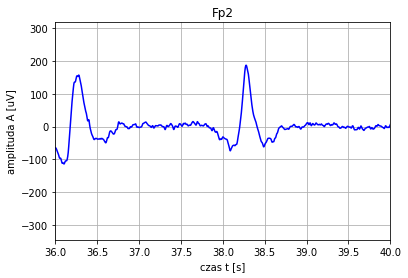

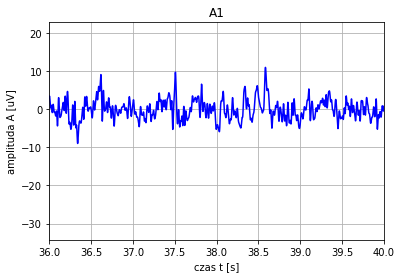

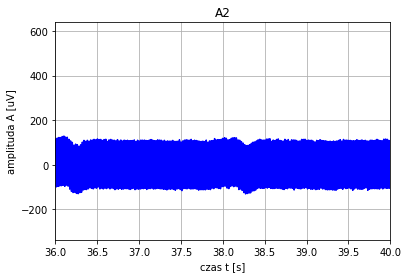

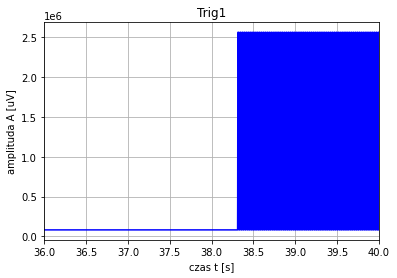

In [7]:
#plotowanie kawałka sygnału
tp,tk=36,40
t1=np.arange(0,len(Fdane1[0])/fs,1/fs)
t2=np.arange(0,len(Fdane2[0])/fs,1/fs)
for i in range(len(Nazwy)):
  plt.title(Nazwy[i])
  plt.grid()
  plt.xlim(tp,tk)
  plt.xlabel('czas t [s]')
  plt.ylabel('amplituda A [uV]')
  plt.plot(t1,Fdane1[i],'b')
  plt.show()



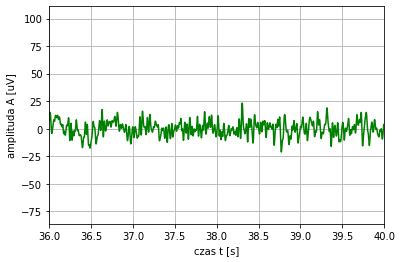

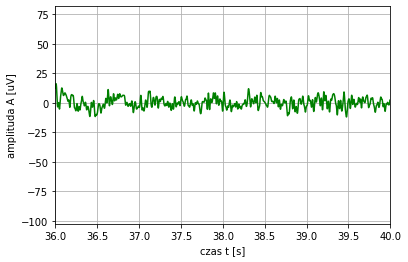

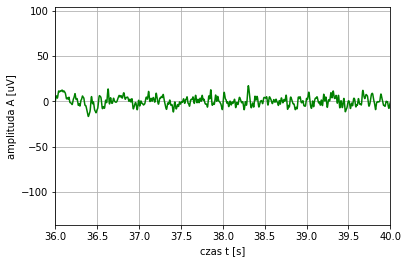

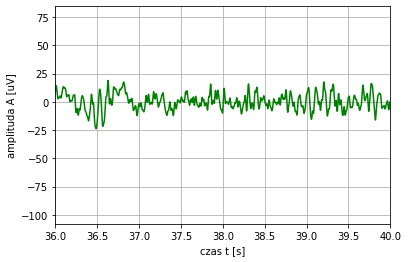

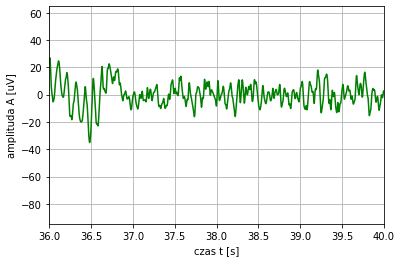

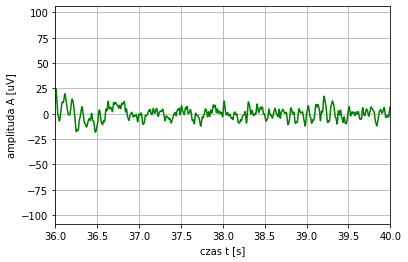

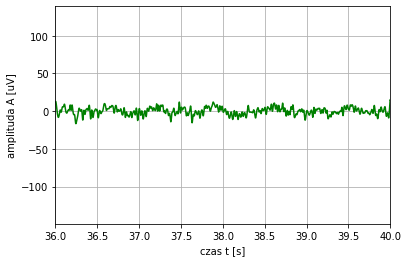

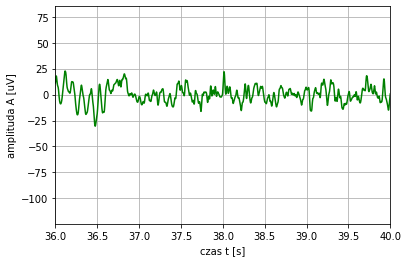

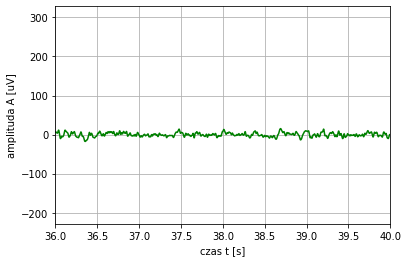

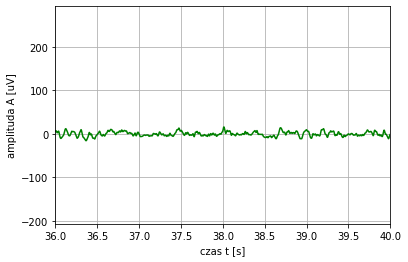

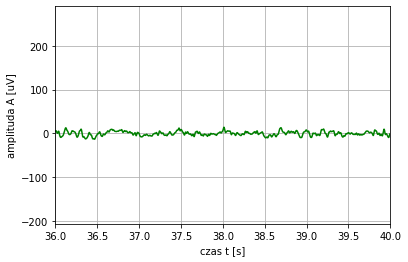

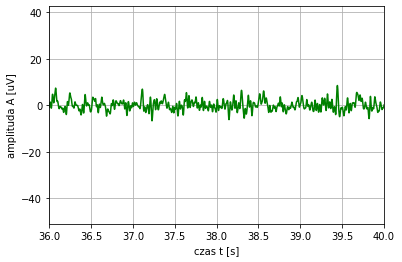

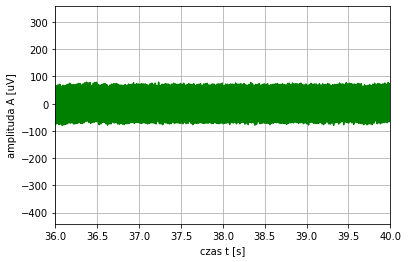

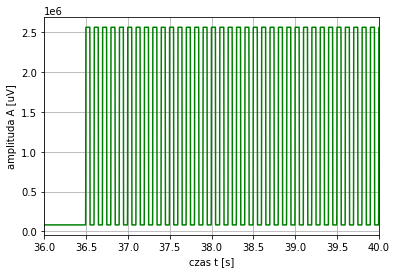

In [8]:
for i in range(len(Nazwy)):
  plt.grid()
  plt.xlim(tp,tk)
  plt.xlabel('czas t [s]')
  plt.ylabel('amplituda A [uV]')
  plt.plot(t2,Fdane2[i],'g')
  plt.show()


#Szukanie momentów wystapienia bodźców

In [9]:


trig = np.zeros(150) #macierz czasow wystapienia danego trigera o danej czestotliwosc - triger to poczatek bodzca ktory trwał 5s

k = 0
l = 0
while k < len(Fdane1[13]):
  if Fdane1[13,k] > 2500000:
    trig[l] = k
    k+= 7*1024
    l+=1
  else:
    k+=1


trig= trig / fs

#print(trig)


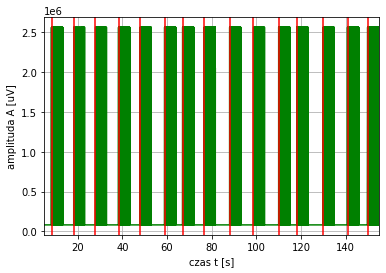

In [10]:
tp,tk = 5,155
plt.grid()
plt.xlim(tp,tk)
plt.xlabel('czas t [s]')
plt.ylabel('amplituda A [uV]')
plt.plot(t1,Fdane1[13],'g')
for x in trig:
  plt.axvline(x,color='red')
plt.show()


In [11]:
fstimuli11=fstimuli1[1:,0]

F1 = np.array([4, 7, 10, 13, 16, 20, 25, 30, 35, 40])
idxmatrix = np.zeros(150).reshape(10,15)

a = 0
for x in F1:
  idxmatrix[a] = np.where(fstimuli11 == x)[0]
  a+=1


trigf=np.zeros(150).reshape(10,15)

for i in range(10):
  l=0
  for x in idxmatrix[i]:
    trigf[i,l]=trig[int(x)]
    l+=1


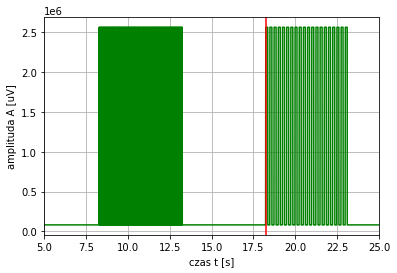

18666


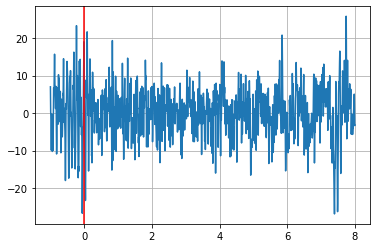

In [12]:

tp,tk = 5,25
plt.grid()
plt.xlim(tp,tk)
plt.xlabel('czas t [s]')
plt.ylabel('amplituda A [uV]')
plt.plot(t1,Fdane1[13],'g')
for x in trigf[0]: #[4, 7, 10, 13, 16, 20, 25, 30, 35, 40]
  plt.axvline(x,color='red')
plt.show()

#pięknie markuje chwile czasu w którym pojawił się bodziec o danej częstotliwości

tpocz=1
tkon=8
plt.grid()
print(int(trigf[0][0]*fs))
osx=np.arange(-tpocz,tkon,1/fs)
plt.plot(osx,Fdane1[0][int((trigf[0][0]-tpocz)*fs):int((trigf[0][0]+tkon)*fs)])
plt.axvline(0,color='red')
plt.show()

In [13]:

from scipy.fftpack import fft
from scipy.signal import blackman
# Number of sample points
import numpy.fft as fft
# sample spacing
def widmo_mocy(s,Fs):
  '''funkcja oblicza widmo mocy sygnału rzeczywistego i oś częstości
  s - sygnał
  Fs - częstość próbkowania

  zwraca dodatnią część widma
  '''
  S = fft.rfft(s)/np.sqrt(len(s))
  S_moc = np.abs(S)**2
  S_moc = S_moc.real
  F = fft.rfftfreq(len(s), 1/Fs)
  return (S_moc,F)

#y1= Fdane1[0][int((trigf[3][3]-tpocz)*fs):int((trigf[3][3]+tkon)*fs)]
N = int((tpocz+tkon)*fs)
T = 1/fs
w = blackman(N)
sredniamatrix = np.zeros(len(F1)*(N//2+1)).reshape(10,(N//2+1)) 
for i in range(len(trigf)):
  sredniafft=np.zeros(N//2+1)
  for j in range(len(trigf[0])): #dla jednej konkretnje częstoliwości uśredniamy
    y = Fdane1[0][int((trigf[i][j]-tpocz)*fs):int((trigf[i][j]+tkon)*fs)]
    S,F=widmo_mocy(y,fs)
    sredniafft  += S

  #sredniafft = sredniafft / 15
  sredniamatrix[i] = sredniafft

#  xf = np.linspace(0.0, 1.0/(2.0*T), N)
#  plt.title(F1[i])
#  plt.plot(F, sredniafft, 'g')
#  plt.axvline(F1[i],color='r')
#  plt.ylim(0,3000)
#  plt.xlim(0,45)
#  plt.grid()
#  plt.show()

#print(sredniafft[49])


## Dla drugiegiej części sygnału



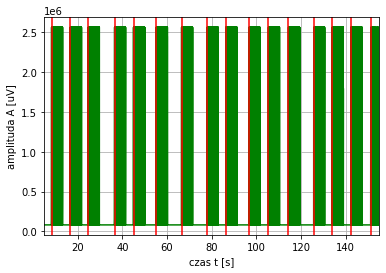

In [14]:


trig2 = np.zeros(150) #macierz czasow wystapienia danego trigera o danej czestotliwosc - triger to poczatek bodzca ktory trwał 5s

k = 0
l = 0
while k < len(Fdane2[13]):
  if Fdane2[13,k] > 2500000:
    trig2[l] = k
    k+= 7*1024
    l+=1
  else:
    k+=1


trig2= trig2 / fs

#print(trig2)

tp,tk = 5,155
plt.grid()
plt.xlim(tp,tk)
plt.xlabel('czas t [s]')
plt.ylabel('amplituda A [uV]')
plt.plot(t2,Fdane2[13],'g')
for x in trig2:
  plt.axvline(x,color='red')
plt.show()



In [15]:
fstimuli22=fstimuli2[1:,0]
print('fstimuli22',fstimuli22) #sprawdx czy przypadkie nie zassało z pamięci

F1 = np.array([4, 7, 10, 13, 16, 20, 25, 30, 35, 40])
idxmatrix2 = np.zeros(150).reshape(10,15)

a = 0
for x in F1:
  idxmatrix2[a] = np.where(fstimuli22 == x)[0]
  a+=1
#print('idxmatrix2',idxmatrix2)
#kazdy wers w idxmatrix to nr indeksu w trig dla zadanej f
#print(idxmatrix)

trigf2=np.zeros(150).reshape(10,15)

for i in range(10):
  l=0
  for x in idxmatrix2[i]:
    trigf2[i,l]=trig2[int(x)]
    l+=1

#print('trigOdF2',trigf2)
#trigf to punkty w czasie wystapenia danego bodzca



fstimuli22 [10. 35. 20. 10. 20. 30. 10. 13. 30. 10. 13. 35.  7. 25. 35.  4.  7. 40.
 35. 20.  7.  4. 10. 30. 25. 30. 40. 20. 10. 13. 40. 25.  7. 30. 25. 40.
 13. 35. 25. 13. 25.  7.  4. 13. 35. 30. 35. 40. 25. 16.  4. 20.  7. 40.
 20. 40. 30.  7. 13. 40. 10. 13. 10.  4.  7.  4. 20. 35. 30. 16.  4.  7.
 16.  4. 13.  7. 30. 20. 16. 20. 25. 20. 10. 16. 13. 25. 40.  7. 13. 30.
  7. 20. 25. 40. 35.  7. 35. 16. 40. 13. 10.  4. 10.  4.  7. 35. 16. 40.
 35. 16. 20. 10. 30.  4. 20. 30. 16. 25.  4. 16. 25.  7. 10. 13. 40. 35.
  4. 30. 20. 10. 40. 25. 16. 13. 25. 35. 16. 10. 20. 35. 16.  4. 25. 16.
  4. 30. 16. 30. 40. 13.]


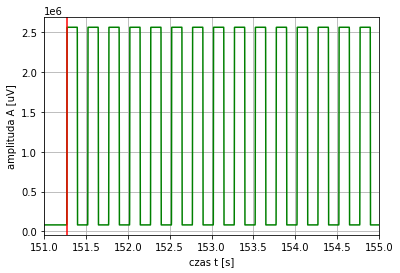

154903


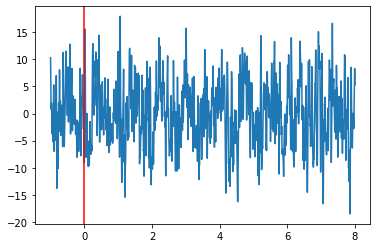

In [16]:

tp,tk = 151,155
plt.grid()
plt.xlim(tp,tk)
plt.xlabel('czas t [s]')
plt.ylabel('amplituda A [uV]')
plt.plot(t2,Fdane2[13],'g')
for x in trigf2[0]: #KOLEJNOSC [4, 7, 10, 13, 16, 20, 25, 30, 35, 40]
  plt.axvline(x,color='red')
plt.show()

#pięknie markuje chwile czasu w którym pojawił się bodziec o danej częstotliwości

tpocz=1
tkon=8
print(int(trigf2[0][0]*fs))
osx=np.arange(-tpocz,tkon,1/fs)
plt.plot(osx,Fdane2[0][int((trigf2[0][0]-tpocz)*fs):int((trigf2[0][0]+tkon)*fs)])
plt.axvline(0,color='red')
plt.show()






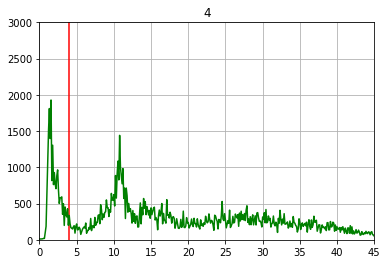

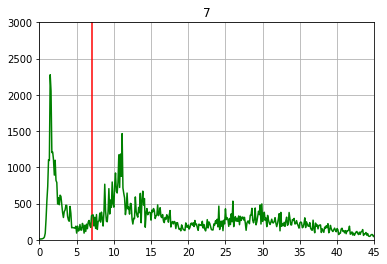

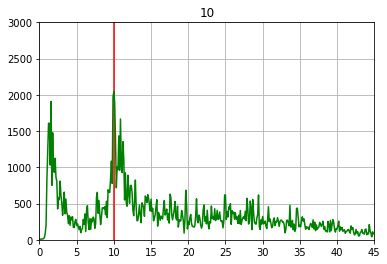

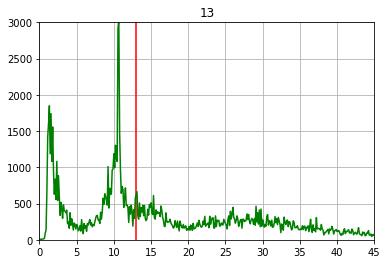

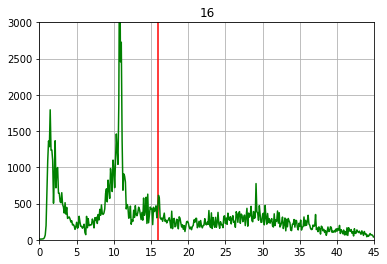

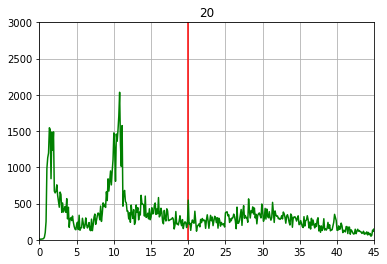

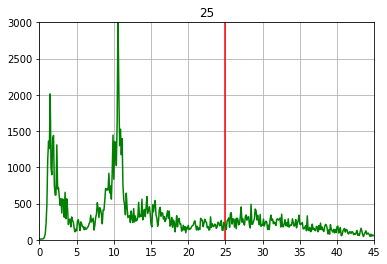

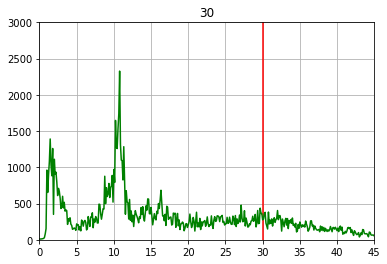

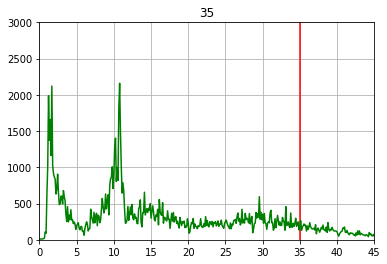

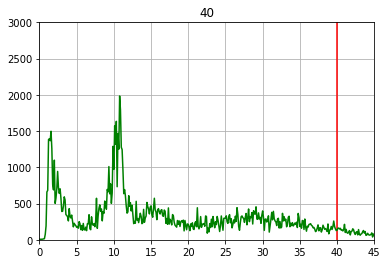

In [17]:
#dodawanie elemtów do średniej z drugiej sygnału (oczywiscie srednia liczymy dopiero na koncu)
ansSSVEP = np.zeros(len(F1))
otherSSVEP = np.zeros(10*(len(F1))).reshape(10,(len(F1)))
for i in range(len(trigf)):
  sredniafft=np.zeros(N//2+1)
  for j in range(len(trigf[0])): #dla jednej konkretnje częstoliwości uśredniamy
    y = Fdane2[0][int((trigf2[i][j]-tpocz)*fs):int((trigf2[i][j]+tkon)*fs)]
    S,F=widmo_mocy(y,fs)
    sredniafft  += S

  #sredniafft = sredniafft / 15
  sredniamatrix[i] = sredniafft


  sredniamatrix[i] = sredniamatrix[i]/30 #srednia ze wszystkcih realizacji w danej częstości
  for l in range(10):
    otherSSVEP[i,l]=sredniamatrix[i,np.where(F==F1[l])]
  
  xf = np.linspace(0.0, 1.0/(2.0*T), N)
  plt.title(F1[i])
  plt.axvline(F1[i],color='red')
  plt.plot(F, sredniamatrix[i], 'g')
  plt.ylim(0,3000)
  plt.xlim(0,45)
  #plt.xlim(F1[i]-2,F1[i]+2)
  plt.grid()
  plt.show()
  
  ansSSVEP[i]=sredniamatrix[i,np.where(F==F1[i])]




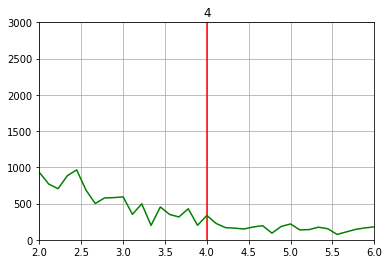

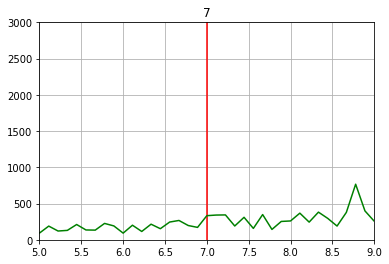

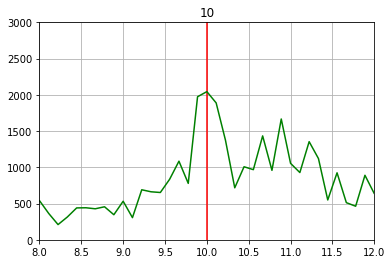

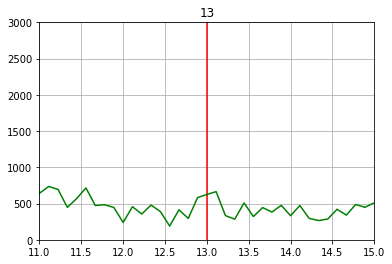

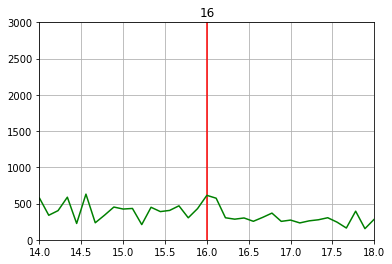

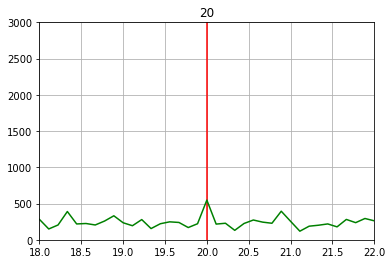

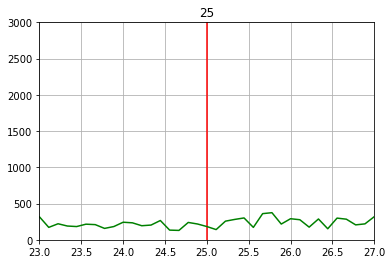

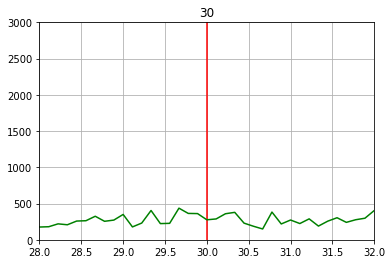

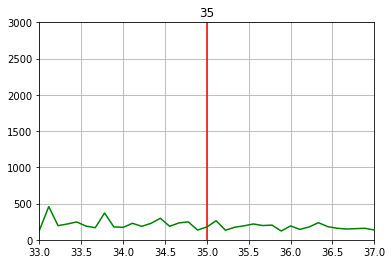

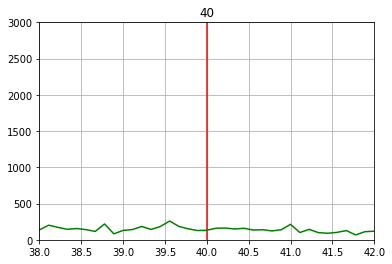

[ 336.20960939  332.91424487 2044.30766878  625.41262298  613.30996343
  547.61910408  182.97672934  275.87169269  177.06361539  132.34533558]


In [18]:
#przybliżenie wyglądu widma
for i in range(len(F1)):
  plt.title(F1[i])
  plt.axvline(F1[i],color='red')
  plt.plot(F, sredniamatrix[i], 'g')
  plt.ylim(0,3000)
  #plt.xlim(0,45)
  plt.xlim(F1[i]-2,F1[i]+2)
  plt.grid()
  plt.show()
  #ansSSVEP[i]=sredniamatrix[i,np.where(F==F1[i])]
print(ansSSVEP)

##bootstrap dla szukania istotności
